Реализуем Алгоритм Метрополиса — Гастингса

In [1]:
# %load mcmc_sampler.py
import numpy
from scipy import stats


class MCMCSampler:
    def __init__(self, target_pdf):
        self.target_pdf = target_pdf
        self.uniform = stats.uniform()

    def sample(self, x_0, sample_from_proposal_fun, n_samples, discard_first=0):
        x_prev = x_0
        for i in range(discard_first):
            self.sample_next(sample_from_proposal_fun, x_prev)

        result = []
        for i in range(n_samples):
            result.append(x_prev)
            x_prev = self.sample_next(sample_from_proposal_fun, x_prev)
        return numpy.array(result)

    def sample_next(self, sample_from_proposal_fun, x_prev):
        proposed_x = sample_from_proposal_fun(x_prev)
        acceptance_probability = min(self.target_pdf(proposed_x) / self.target_pdf(x_prev), 1)
        if acceptance_probability >= self.uniform.rvs():
            x_prev = proposed_x
        return x_prev


Определим:
- PDF и CDF распределения из которого будем генерировать семплы. Будем рассматривать смесь двух нормальных.
- функцию для создания вспомогательных распределений `create_sample_from_random_walk_proposal_fun`
- размер семпла
- функцию семплирования и визуализации $D_n$ статистики


In [2]:
# %load mcmc.py
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import plots
import tests
from mcmc_sampler import MCMCSampler

multivariate_normal1 = stats.multivariate_normal([0], [[0.5]])
multivariate_normal2 = stats.multivariate_normal([-4], [[0.5]])
bernoulli = stats.bernoulli(0.4)


def naive_rvs(size):
    ber = bernoulli.rvs(size)
    n1 = multivariate_normal1.rvs(size)
    n2 = multivariate_normal2.rvs(size)
    return [n1[i] if (ber[i] == 1) else n2[i] for i in range(size)]


def pdf(x): return 0.4 * multivariate_normal1.pdf(x) + 0.6 * multivariate_normal2.pdf(x)


def cdf(x): return 0.4 * multivariate_normal1.cdf(x) + 0.6 * multivariate_normal2.cdf(x)


def create_sample_from_random_walk_proposal_fun(D):
    normal = stats.multivariate_normal([0], [[D]])
    return lambda x: normal.rvs() + x


sampler = MCMCSampler(pdf)


def n_samples(d, x_0, sample_size, n, discard_first=0):
    return [sampler.sample(x_0, create_sample_from_random_walk_proposal_fun(d), sample_size,
                           discard_first=discard_first) for i in range(n)]


def ks_test(samples, cdf, ks_test_points):
    return [tests.kstest(sample, cdf, ks_test_points) for sample in samples]


def lr_test(samples, cdf, ks_test_points):
    return [tests.lrtest_1dim(sample, cdf, ks_test_points) for sample in samples]


def sample_and_plot(ds, use_mean_of=20, discard_first=500, sample_size=10000):
    test_points = np.unique(np.logspace(np.log10(sample_size) - 2, np.log10(sample_size - 1), num=10, dtype=int))

    samples = []
    ks_statistics = []
    lr_statistics = []
    for d in ds:
        samples_for_current_proposal = n_samples(d, 0, sample_size, use_mean_of, discard_first=discard_first)
        ks_statistics_for_current_proposal = ks_test(samples_for_current_proposal, cdf, test_points)
        lr_statistics_for_current_proposal = lr_test(samples_for_current_proposal, naive_rvs(sample_size), test_points)

        samples.append(samples_for_current_proposal)
        ks_statistics.append(np.average(ks_statistics_for_current_proposal, axis=0))
        lr_statistics.append(np.average(lr_statistics_for_current_proposal, axis=0))

    labels = ["D=" + str(i) for i in ds]

    plots.plot_cdf_and_ecdfs([s[0] for s in samples], cdf, labels)
    plots.plot_pdf_and_histograms([s[0] for s in samples], pdf, labels)
    plots.plot_ks(test_points, ks_statistics, labels)
    plots.plot_lr(test_points, lr_statistics, labels)
    plt.show()


Попробуем найти подходящее значение дисперсии вспомогательного распределения.
Сначала найдем подходящий порядок.

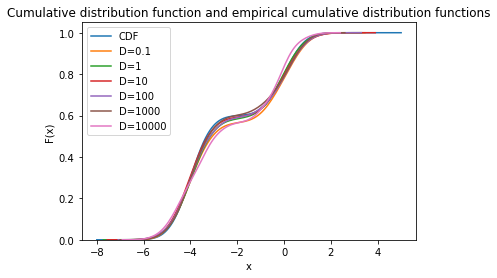

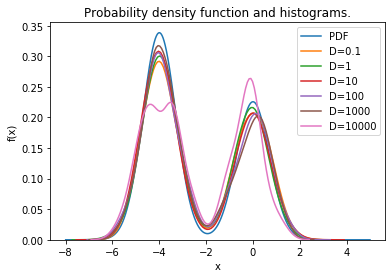

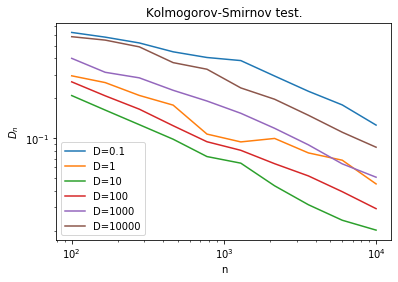

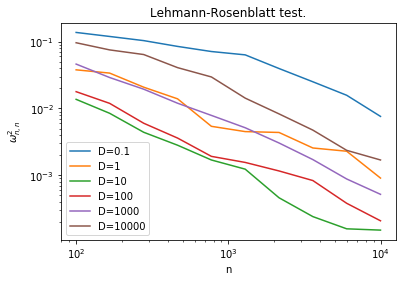

In [3]:
sample_and_plot([0.1, 1, 10, 100, 1000,10000], discard_first=500)

Угол наклона графиков тестовых статистик с логарифмическми шкалами позволяет оценить скорость сходимости.
Попробуем некоторые значения из $[1,100]$

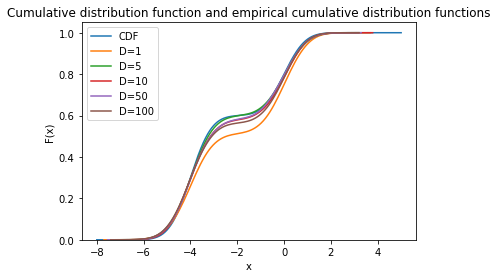

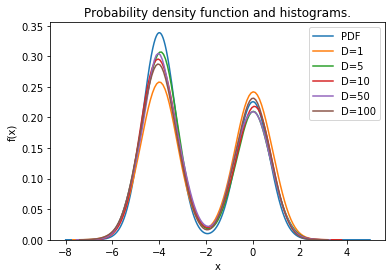

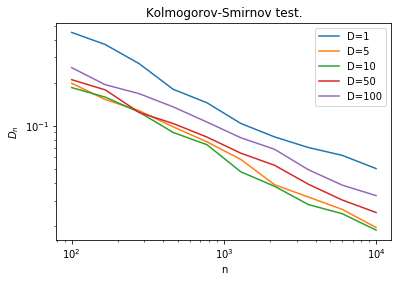

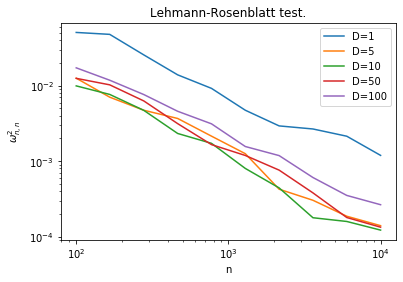

In [4]:
sample_and_plot([1, 5, 10, 50, 100], discard_first=500)

1 хуже других.
Попробуем некоторые значения из $[2,100]$ и увеличим размер выборки.

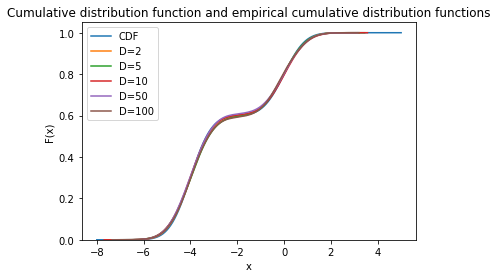

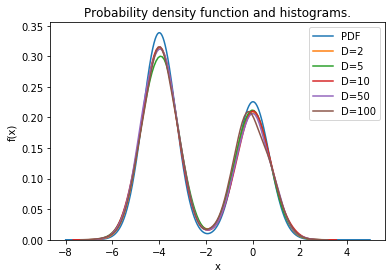

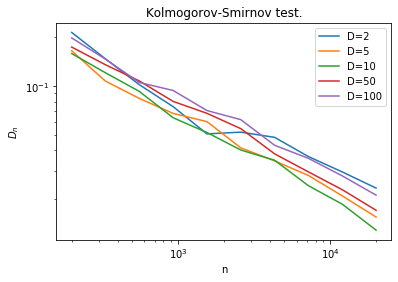

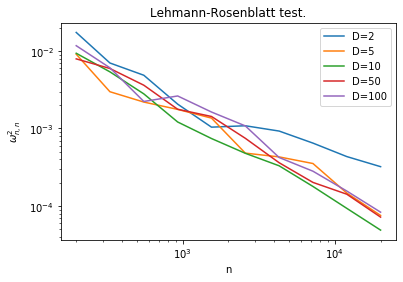

In [3]:
sample_and_plot([2, 5, 10, 50, 100] ,sample_size=20000, discard_first=500)

2 хуже других.\
Наклон графиков для остальных значений визуально не отличим.\
В качестве вспомогательного распределения хорошо использовать $\mathcal {N}(0,D)$,где $D \in [5,100]$